###  Gaussian Classifier

Apply the MVG model to the project data. Split the dataset in model training and validation subsets
(important: use the same splits for all models, including those presented in other laboratories), train the
model parameters on the model training portion of the dataset and compute LLRs

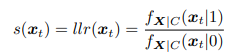

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg


In [301]:
def vcol(x):
    return x.reshape((x.size, 1))

In [302]:
def vrow(x):
    return x.reshape((1, x.size))

In [303]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [304]:
#prima di essre processati i dati devono essere spostati nell origini, ovvero avere media 0
def compute_mu_C(X):
    "Calcolo la media e la matrice di covarianza dei dati x"
    mu = vcol(X.mean(1))

    C = ((X-mu)@(X-mu).T)/float(X.shape[1])
    return mu, C

In [305]:
def logpdf_GAU_ND(X, mu, C):
    """
    Compute the log-density of a multivariate Gaussian distribution for multiple samples.
    X is a 2D numpy array where each column is a sample, mu is the mean vector, and C is the covariance matrix.
    Returns a 1D numpy array of log-density values for each sample.
    """
    P=np.linalg.inv(C) #inverse of covariance matrix (Precision matrix)
    return -0.5*X.shape[0]*np.log(2*np.pi)-0.5*np.linalg.slogdet(C)[1]-0.5* ((X-mu) * (P @ (X-mu))).sum(0) 


In [306]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [307]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)


(i.e., with class True, label 1 on top of the ratio) for the validation subset. Obtain predictions from
LLRs assuming uniform class priors P(C = 1) = P(C = 0) = 1/2. Compute the corresponding error
rate (suggestion: in the next laboratories we will modify the way we compute predictions from LLRs,
we therefore recommend that you keep separated the functions that compute LLRs, those that compute
predictions from LLRs and those that compute error rate from predictions).


### MVG Model

In [308]:
def Gau_MVG_ML_estimation(D,L):
    labelSet=set(L)
    hParams = {}
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C = compute_mu_C(DLabel)
        hParams[label] = (mu, C)
    return hParams


### Tied Model

In [309]:
def Gau_Tied_ML_estimation(D,L):
    labelSet=set(L)
    hParams={}
    hMeans={}
    CGlobal=0
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C_class = compute_mu_C(DLabel)
        hMeans[label] = mu
        CGlobal += C_class*DLabel.shape[1]
    CGlobal=CGlobal/D.shape[1]
    for label in labelSet:
        hParams[label] = (hMeans[label], CGlobal)
    return hParams

In [310]:
def compute_llr_binary(D,hParams):
    """Compute log-likelihood ratio (LLR) for binary classification."""
    llr = logpdf_GAU_ND(D, hParams[1][0], hParams[1][1]) - logpdf_GAU_ND(D, hParams[0][0], hParams[0][1])
    return llr

In [311]:
def compute_prediction_from_llr_binary(llr,trashold=0):
    """Compute binary prediction from log-likelihood ratio (LLR)."""
    predictions=np.zeros(llr.size,dtype=np.int32)
    predictions[llr>=trashold]=1
    predictions[llr<trashold]=0
    return predictions


In [312]:
def compute_prediction_from_llr_binary_with_optimal_threshold(llr,prior,Cfn,Cfp):
    """Compute binary prediction from log-likelihood ratio (LLR) with optimal threshold."""
    # Compute the optimal threshold based on prior probabilities and costs
    threshold = np.log(prior * Cfn / ((1-prior) * Cfp))
    predictions = np.zeros(llr.size, dtype=np.int32)
    predictions[llr >= threshold] = 1
    predictions[llr < threshold] = 0
    return predictions, threshold


### Naive Bayes

In [313]:
def Gau_NaiveBayes_ML_estimation(D,L):
    labelSet=set(L)
    hParams = {}
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C = compute_mu_C(DLabel)
        C = C*np.eye(D.shape[0]) #diagonal covariance matrix
        hParams[label] = (mu, C)
    return hParams

## Analysis of MVG Classifier Performance under Different Application Scenarios

We'll analyze the Gaussian classifiers (MVG, Tied, Naive Bayes) under different application scenarios characterized by various priors and costs.

### Application Scenarios
Each scenario is defined by a tuple (π₁, Cfn, Cfp) where:
- π₁ is the prior probability of class 1 (genuine samples)
- Cfn is the cost of false negatives (rejecting genuine samples)
- Cfp is the cost of false positives (accepting fake samples)

### Effective Prior Analysis
The effective prior π̃₁ can be calculated as:

π̃₁ = (π₁ × Cfn) / (π₁ × Cfn + (1-π₁) × Cfp)

For our five applications:

1. **(0.5, 1.0, 1.0)**: Uniform prior and costs
    - π̃₁ = 0.5
    - Balanced decision threshold

2. **(0.9, 1.0, 1.0)**: Higher genuine probability
    - π̃₁ = 0.9
    - Favors accepting samples as genuine

3. **(0.1, 1.0, 1.0)**: Higher impostor probability
    - π̃₁ = 0.1
    - Favors rejecting samples as impostors

4. **(0.5, 1.0, 9.0)**: Higher false positive cost (security-focused)
    - π̃₁ = 0.1
    - Equivalent to having fewer legitimate users

5. **(0.5, 9.0, 1.0)**: Higher false negative cost (convenience-focused)
    - π̃₁ = 0.9
    - Equivalent to having more legitimate users

### Key Observation
The costs of misclassification directly affect the effective prior. Higher security requirements (increased false positive costs) mathematically translate to a lower effective prior probability for legitimate users. This makes the system more conservative in granting access, prioritizing security over convenience.

In [314]:
def compute_confusion_matrix(predictedLabels, classLabels):
    nClasses = classLabels.max() + 1
    M = np.zeros((nClasses, nClasses), dtype=np.int32) #
    ### M[i,j] = number of instances of class i that were predicted to be class j
    for i in range(classLabels.size):
        M[predictedLabels[i], classLabels[i]] += 1
    return M


In [315]:
# Compute confusion matrices for all the applications
applications = [
    (0.5, 1.0, 1.0, "Uniform prior and costs"),
    (0.9, 1.0, 1.0, "High probability of genuine samples"),
    (0.1, 1.0, 1.0, "High probability of fake samples"),
    (0.5, 1.0, 9.0, "High cost for false positives (security)"),
    (0.5, 9.0, 1.0, "High cost for false negatives (usability)")
]

In [316]:
#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)

for prior,  costFN ,costFP, description in applications:
    #Optimal threshold following the Bayes decision rule
    threshold = np.log((prior * costFN) / ((1 - prior) * costFP))

    #Compute predictions for each model
    predictions_mvg = compute_prediction_from_llr_binary(llr_mvg, threshold)
    predictions_tied = compute_prediction_from_llr_binary(llr_tied, threshold)
    predictions_naive = compute_prediction_from_llr_binary(llr_naive, threshold)
    #Compute confusion matrices for each model
 # Calcola e stampa le performance
    print(f"Application: {description}")
    print(f"Parameters: π₁={prior}, Cfn={costFN}, Cfp={costFP}, threshold={threshold:.4f}")
    
    # Matrici di confusione
    print("Confusion Matrices:")
    print("MVG:")
    print(compute_confusion_matrix(predictions_mvg, LVAL))
    print("Tied:")
    print(compute_confusion_matrix(predictions_tied, LVAL))
    print("Naive Bayes:")
    print(compute_confusion_matrix(predictions_naive, LVAL))
    print("-" * 50)


Application: Uniform prior and costs
Parameters: π₁=0.5, Cfn=1.0, Cfp=1.0, threshold=0.0000
Confusion Matrices:
MVG:
[[927  75]
 [ 65 933]]
Tied:
[[898  92]
 [ 94 916]]
Naive Bayes:
[[925  77]
 [ 67 931]]
--------------------------------------------------
Application: High probability of genuine samples
Parameters: π₁=0.9, Cfn=1.0, Cfp=1.0, threshold=2.1972
Confusion Matrices:
MVG:
[[988 271]
 [  4 737]]
Tied:
[[983 327]
 [  9 681]]
Naive Bayes:
[[988 268]
 [  4 740]]
--------------------------------------------------
Application: High probability of fake samples
Parameters: π₁=0.1, Cfn=1.0, Cfp=1.0, threshold=-2.1972
Confusion Matrices:
MVG:
[[728  15]
 [264 993]]
Tied:
[[666  15]
 [326 993]]
Naive Bayes:
[[721  13]
 [271 995]]
--------------------------------------------------
Application: High cost for false positives (security)
Parameters: π₁=0.5, Cfn=1.0, Cfp=9.0, threshold=-2.1972
Confusion Matrices:
MVG:
[[728  15]
 [264 993]]
Tied:
[[666  15]
 [326 993]]
Naive Bayes:
[[721  13]


Confusion matrices are organized as follows:  
```
[[TN  FP]
 [FN  TP]]
```
where:
- **TN (True Negatives):** fingerprints correctly classified as fake (label 0)  
- **FP (False Positives):** fake fingerprints incorrectly classified as genuine  
- **FN (False Negatives):** genuine fingerprints incorrectly classified as fake  
- **TP (True Positives):** fingerprints correctly classified as genuine (label 1)  

### Correct Analysis of the Results

1. **For the application with uniform priors and costs (threshold = 0):**  
   - MVG: 75 false positives (fake fingerprints accepted as genuine) and 65 false negatives (genuine fingerprints rejected)  
   - Tied: 92 false positives and 94 false negatives  
   - Naive Bayes: 77 false positives and 67 false negatives  

   The MVG model continues to deliver the best overall performance.

2. **For user-friendly applications (threshold = 2.1972):**  
   - MVG: 271 false positives and 4 false negatives  
   - Tied: 327 false positives and 9 false negatives  
   - Naive Bayes: 268 false positives and 4 false negatives  

   These applications prioritize user experience (minimal rejection of genuine fingerprints), thus accepting a high number of false positives to minimize false negatives.

3. **For security-oriented applications (threshold = -2.1972):**  
   - MVG: 15 false positives and 264 false negatives  
   - Tied: 15 false positives and 326 false negatives  
   - Naive Bayes: 13 false positives and 271 false negatives  

   These applications prioritize security by minimizing the acceptance of fake fingerprints (false positives), even at the cost of a high rejection rate of genuine ones.

### Conclusions

1. **Confirmation of the relationship between costs and priors:**  
   The analysis confirms that misclassification costs are reflected in the effective prior. Greater security (higher cost for false positives) corresponds to a threshold that drastically reduces false positives, even at the cost of increasing false negatives.

2. **Model comparison:**  
   - For balanced scenarios: standard MVG is the best  
   - For user-friendly scenarios: Naive Bayes slightly outperforms MVG  
   - For security-oriented scenarios: Naive Bayes has the lowest number of false positives (13 vs 15)  
   - The Tied model consistently performs the worst  

3. **Security vs usability trade-off:**  
   - With threshold = 2.1972 (usability): few false negatives (4–9) but many false positives (268–327)  
   - With threshold = -2.1972 (security): few false positives (13–15) but many false negatives (264–326)  

This analysis clearly demonstrates how adjusting the decision threshold based on priors and costs allows the classifier's behavior to be tailored to the specific needs of the application.

We now focus on the three applications, represented in terms of effective priors (i.e., with costs of errors
equal to 1) given by  ̃π = 0.1,  ̃π = 0.5 and  ̃π = 0.9, respectively.
For these three applications, compute the optimal Bayes decisions for the validation set for the MVG
models and its variants (to limit the number of experiments, do not consider any pre-processing — in real
tasks, however, it may be worth analyzing also the effects of pre-processing strategies like, for example,
PCA). Compute actual DCF and minimum DCF for the different models. Compare the models in terms
of minimum DCF. Which models perform best? Are the relative results of the models consistent over
the different applications? Now consider also actual DCFs. Are the models well calibrated (i.e., with a
calibration loss in the range of few percents of the minimum DCF value) for the given applications? Are
there models that are better calibrated than others for the different applications?
Compute the Bayes error plots for the MVG, Tied and Naive Bayes Gaussian classifiers. For each
model plot both minimum and actual DCF. Consider prior log odds in the range (−4,+4). What do you
observe? Are model rankings consistent across applications (minimum DCF)? Are models well-calibrated
over the considered range of applications?
9

In [317]:
def compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=True):
    "Commpute actual DCF"
    CM=compute_confusion_matrix(predictedLabels, classLabels)
    # Pfn (falsi negativi / tutti i positivi)
    # CM[0,1] = numero di campioni di classe 1 (positivi) predetti come classe 0 (negativi)
    # CM[1,1] = numero di campioni di classe 1 (positivi) predetti come classe 1 (positivi)
    Pfn = CM[0,1] / (CM[0,1] + CM[1,1]) if (CM[0,1] + CM[1,1]) > 0 else 0
    
    # Pfp (falsi positivi / tutti i negativi)
    # CM[1,0] = numero di campioni di classe 0 (negativi) predetti come classe 1 (positivi)
    # CM[0,0] = numero di campioni di classe 0 (negativi) predetti come classe 0 (negativi)
    Pfp = CM[1,0] / (CM[0,0] + CM[1,0]) if (CM[0,0] + CM[1,0]) > 0 else 0

    bayesError=prior*Pfn*Cfn+(1-prior)*Pfp*Cfp
    if normalize:
        return bayesError / np.minimum(prior * Cfn, (1-prior)*Cfp)
    return bayesError

In [318]:
def compute_minDCF_binary(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False):
    # Ordina i punteggi e le etichette
       
    # Calcola il numero di campioni positivi e negativi
    n_pos = (classLabels == 1).sum()
    n_neg = (classLabels == 0).sum()
    
    # Inizializza il DCF minimo
    min_dcf = float('inf')
    best_threshold = None
    
    # Considera ogni valore unico di llr come soglia
    thresholds = np.unique(np.concatenate([[-np.inf], llr, [np.inf]]))
    
    for t in thresholds:
        # Calcola le predizioni per questa soglia
        predictions = (llr > t).astype(np.int32)
        
        # Calcola il numero di falsi negativi e falsi positivi
        fn = np.sum((predictions == 0) & (classLabels == 1))
        fp = np.sum((predictions == 1) & (classLabels == 0))
        
        # Calcola i tassi di errore
        fnr = fn / n_pos if n_pos > 0 else 0  # False negative rate
        fpr = fp / n_neg if n_neg > 0 else 0  # False positive rate
        
        # Calcola il DCF normalizzato
        dcf = (prior * Cfn * fnr + (1 - prior) * Cfp * fpr) / np.minimum(prior * Cfn, (1 - prior) * Cfp)
        
        # Aggiorna il minimo se necessario
        if dcf < min_dcf:
            min_dcf = dcf
            best_threshold = t
    
    if returnThreshold:
        return min_dcf, best_threshold
    else:
        return min_dcf

In [319]:
# Analisi delle tre applicazioni con priori effettive
pi_tilde_values = [0.1, 0.5, 0.9]

# Tabella di confronto
print("Analisi dei classificatori MVG per le tre priori effettive:")
print("-" * 80)
print(f"{'Model':<12} {'π̃':<5} {'actDCF':<10} {'minDCF':<10} {'Calib. Loss (%)':<15}")
print("-" * 80)

for pi_tilde in pi_tilde_values:
    # Calcola la soglia ottimale teorica
    threshold = -np.log(pi_tilde / (1 - pi_tilde))
    
    # MVG model
    predictions_mvg = compute_prediction_from_llr_binary(llr_mvg, threshold)
    act_dcf_mvg = compute_empirical_Bayes_risk_binary(predictions_mvg, LVAL, pi_tilde, 1, 1)
    min_dcf_mvg = compute_minDCF_binary(llr_mvg, LVAL, pi_tilde, 1, 1)
    calib_loss_mvg = ((act_dcf_mvg - min_dcf_mvg) / min_dcf_mvg) * 100
    
    # Tied model
    predictions_tied = compute_prediction_from_llr_binary(llr_tied, threshold)
    act_dcf_tied = compute_empirical_Bayes_risk_binary(predictions_tied, LVAL, pi_tilde, 1, 1)
    min_dcf_tied = compute_minDCF_binary(llr_tied, LVAL, pi_tilde, 1, 1)
    calib_loss_tied = ((act_dcf_tied - min_dcf_tied) / min_dcf_tied) * 100
    
    # Naive Bayes model
    predictions_naive = compute_prediction_from_llr_binary(llr_naive, threshold)
    act_dcf_naive = compute_empirical_Bayes_risk_binary(predictions_naive, LVAL, pi_tilde, 1, 1)
    min_dcf_naive = compute_minDCF_binary(llr_naive, LVAL, pi_tilde, 1, 1)
    calib_loss_naive = ((act_dcf_naive - min_dcf_naive) / min_dcf_naive) * 100
    
    # Stampa risultati
    print(f"{'MVG':<12} {pi_tilde:<5.1f} {act_dcf_mvg:<10.4f} {min_dcf_mvg:<10.4f} {calib_loss_mvg:<15.2f}")
    print(f"{'Tied':<12} {pi_tilde:<5.1f} {act_dcf_tied:<10.4f} {min_dcf_tied:<10.4f} {calib_loss_tied:<15.2f}")
    print(f"{'Naive Bayes':<12} {pi_tilde:<5.1f} {act_dcf_naive:<10.4f} {min_dcf_naive:<10.4f} {calib_loss_naive:<15.2f}")
    print("-" * 80)

Analisi dei classificatori MVG per le tre priori effettive:
--------------------------------------------------------------------------------
Model        π̃    actDCF     minDCF     Calib. Loss (%)
--------------------------------------------------------------------------------
MVG          0.1   0.3051     0.2629     16.06          
Tied         0.1   0.4061     0.3628     11.91          
Naive Bayes  0.1   0.3022     0.2570     17.59          
--------------------------------------------------------------------------------
MVG          0.5   0.1399     0.1302     7.50           
Tied         0.5   0.1860     0.1812     2.64           
Naive Bayes  0.5   0.1439     0.1311     9.76           
--------------------------------------------------------------------------------
MVG          0.9   0.4001     0.3423     16.87          
Tied         0.9   0.4626     0.4421     4.63           
Naive Bayes  0.9   0.3893     0.3510     10.92          
----------------------------------------------

### Performance Analysis for the Three Effective Priors

#### Comparison in Terms of minDCF  
The minDCF represents the best performance the classifier could achieve with an optimal threshold:

- For π̃ = 0.1 (security-oriented):  
  * Naive Bayes has the lowest minDCF (0.2570)  
  * Followed by MVG (0.2629)  
  * Tied performs the worst (0.3628)  

- For π̃ = 0.5 (neutral scenario – best case in terms of gain):  
  * MVG has the lowest minDCF (0.1302)  
  * Closely followed by Naive Bayes (0.1311)  
  * Tied performs the worst (0.1812)  

- For π̃ = 0.9 (user-friendliness-oriented):  
  * MVG has the lowest minDCF (0.3423)  
  * Followed by Naive Bayes (0.3510)  
  * Tied performs the worst (0.4421)  

In general, MVG and Naive Bayes are very close in terms of performance, while the Tied model consistently performs the worst.

### Model Calibration  
Calibration loss (percentage difference between actDCF and minDCF) indicates how well the models' scores are calibrated:

- For π̃ = 0.1:  
  * Tied is the best calibrated (11.91% loss)  
  * MVG (16.06% loss)  
  * Naive Bayes is the worst calibrated (17.59% loss)  

- For π̃ = 0.5:  
  * Tied is the best calibrated (2.64% loss)  
  * MVG (7.50% loss)  
  * Naive Bayes is the worst calibrated (9.76% loss)  

- For π̃ = 0.9:  
  * Tied is the best calibrated (4.63% loss)  
  * Naive Bayes (10.92% loss)  
  * MVG is the worst calibrated (16.87% loss)  

It is interesting to note that although the Tied model has the worst performance in terms of discriminative power (minDCF), it is the best calibrated across all scenarios.

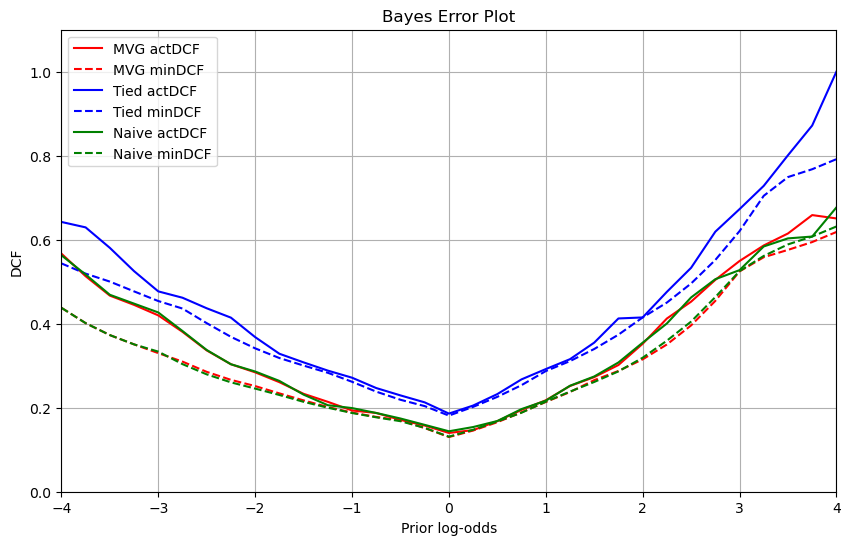

In [320]:
# Bayes error plot
prior_log_odds = np.linspace(-4, 4, 33)  # 33 punti da -4 a +4
prior_tilde = 1 / (1 + np.exp(-prior_log_odds))

# Arrays per salvare i risultati
act_dcf_mvg_plot = []
min_dcf_mvg_plot = []
act_dcf_tied_plot = []
min_dcf_tied_plot = []
act_dcf_naive_plot = []
min_dcf_naive_plot = []

# Calcola DCF per ogni priori
for pi_tilde in prior_tilde:
    # MVG
    threshold = -np.log(pi_tilde / (1 - pi_tilde))
    predictions_mvg = compute_prediction_from_llr_binary(llr_mvg, threshold)
    act_dcf_mvg_plot.append(compute_empirical_Bayes_risk_binary(predictions_mvg, LVAL, pi_tilde, 1, 1))
    min_dcf_mvg_plot.append(compute_minDCF_binary(llr_mvg, LVAL, pi_tilde, 1, 1))
    
    # Tied
    predictions_tied = compute_prediction_from_llr_binary(llr_tied, threshold)
    act_dcf_tied_plot.append(compute_empirical_Bayes_risk_binary(predictions_tied, LVAL, pi_tilde, 1, 1))
    min_dcf_tied_plot.append(compute_minDCF_binary(llr_tied, LVAL, pi_tilde, 1, 1))
    
    # Naive Bayes
    predictions_naive = compute_prediction_from_llr_binary(llr_naive, threshold)
    act_dcf_naive_plot.append(compute_empirical_Bayes_risk_binary(predictions_naive, LVAL, pi_tilde, 1, 1))
    min_dcf_naive_plot.append(compute_minDCF_binary(llr_naive, LVAL, pi_tilde, 1, 1))

# Plot dei risultati
plt.figure(figsize=(10, 6))
plt.plot(prior_log_odds, act_dcf_mvg_plot, 'r', label='MVG actDCF')
plt.plot(prior_log_odds, min_dcf_mvg_plot, 'r--', label='MVG minDCF')
plt.plot(prior_log_odds, act_dcf_tied_plot, 'b', label='Tied actDCF')
plt.plot(prior_log_odds, min_dcf_tied_plot, 'b--', label='Tied minDCF')
plt.plot(prior_log_odds, act_dcf_naive_plot, 'g', label='Naive actDCF')
plt.plot(prior_log_odds, min_dcf_naive_plot, 'g--', label='Naive minDCF')
plt.ylim([0, 1.1])
plt.xlim([-4, 4])
plt.xlabel('Prior log-odds')
plt.ylabel('DCF')
plt.grid(True)
plt.legend()
plt.title('Bayes Error Plot')
plt.show()


### Bayes Error Plot Analysis

The Bayes Error Plot illustrates how model performance varies with the logarithmic prior (prior log-odds):

1. **Discriminative Power (minDCF):**  
   - MVG and Naive Bayes have very similar minDCF curves, both significantly better than the Tied model across most of the log-odds range  
   - For very negative log-odds (< -3), Naive Bayes demonstrates the best discriminative power  
   - For central log-odds (around 0), MVG and Naive Bayes are nearly identical  
   - For very positive log-odds (> 3), MVG appears slightly better  

2. **Model Calibration:**  
   - The distance between the actDCF and minDCF curves represents calibration loss  
   - For central log-odds (around 0), all models are well calibrated  
   - For extreme log-odds (both positive and negative), calibration worsens for all models  
   - The Tied model shows the smallest distance between actDCF and minDCF, especially for positive log-odds  
   - MVG shows the worst calibration for very positive log-odds (> 2)  

3. **Overall Behavior:**  
   - The minimum point for all models is around log-odds = 0 (balanced priors)  
   - For negative log-odds (favoring the negative/fake class), models show a gradual increase in DCF  
   - For positive log-odds (favoring the positive/genuine class), models show a steeper increase in DCF  
   - The Tied model shows a more pronounced asymmetric behavior compared to MVG and Naive Bayes  

### Conclusions

1. **Best Models:**  
   - In terms of discriminative power (minDCF), MVG and Naive Bayes are very similar and clearly outperform the Tied model  
   - Naive Bayes performs slightly better for security-oriented applications (π̃ = 0.1)  
   - MVG performs slightly better for neutral (π̃ = 0.5) and user-friendly applications (π̃ = 0.9)  

2. **Consistency of Results:**  
   - The model ranking is fairly consistent across different application scenarios  
   - MVG and Naive Bayes alternate in the top position, with minimal differences  
   - Tied consistently performs the worst in terms of discriminative power  

3. **Calibration:**  
   - None of the models are perfectly calibrated (calibration losses range from 2.64% to 17.59%)  
   - The Tied model is the best calibrated across all scenarios  
   - Calibration is better for π̃ = 0.5 (neutral scenario) for all models  
   - Calibration worsens for asymmetric applications (π̃ = 0.1 and π̃ = 0.9)  

4. **Practical Considerations:**  
   - If the main objective is discriminative power, MVG or Naive Bayes are the best choices  
   - If calibration is particularly important, the Tied model might be considered despite its lower performance  
   - For a good compromise between discriminative power and calibration, Naive Bayes seems to offer the best balance for π̃ = 0.9


**From the detailed analysis of the performance of MVG classifiers (standard, Tied, and Naive Bayes) across various applications, we can draw the following conclusions:**

### Discriminative Power

- **Standard MVG** shows the best overall discriminative power, with the lowest minDCF values in 2 out of 3 applications (π̃ = 0.5 and π̃ = 0.9).  
- **Naive Bayes** is very competitive, with slightly better performance in security-oriented applications (π̃ = 0.1).  
- **Tied MVG** consistently exhibits the worst discriminative power across all applications.

### Calibration

- **Tied MVG**, despite its lower discriminative power, is the best calibrated model in all applications, showing the smallest percentage difference between actDCF and minDCF.  
- **Standard MVG** has reasonable calibration for neutral applications but worsens in asymmetric scenarios.  
- **All models** show significantly improved calibration for applications with balanced priors (π̃ = 0.5).

### Behavior Across Applications

- The **Bayes Error Plot** shows that MVG and Naive Bayes perform very similarly across a wide range of applications.  
- For strongly security-oriented applications (very negative log-odds), **Naive Bayes** offers a slight advantage.  
- For strongly usability-oriented applications (very positive log-odds), **MVG** has a slight edge.  
- **All models** are well calibrated around log-odds = 0 (balanced priors), but calibration deteriorates significantly at the extremes.

### Practical Recommendations

- For **most general-purpose applications**: **Standard MVG** is the most balanced choice, offering the best overall discriminative power with acceptable calibration.  
- For applications with a **strong emphasis on security** (low tolerance for false positives): **Naive Bayes** may offer a slight advantage in discriminative power.  
- For applications where **calibration is critical** (e.g., when threshold re-optimization on validation data is not possible): the **Tied model** could be considered despite its lower discriminative performance.  
- For the **best trade-off**: an effective strategy could be to use **MVG or Naive Bayes** for their good discriminative power, and recalibrate them if needed.
